# Citi Bike Analysis

In [1]:
import calendar
import holidays
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy
import seaborn as sns

from datetime import datetime
from plotly.subplots import make_subplots
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_pipeline

## Read the prepared CSV

In [2]:
df_nyc = pd.read_csv("nyc-daily.csv", parse_dates=["date"], index_col=0)
df_nyc.tail()

,date,count,Year,Month,Week,Day,Day of Week,Day of Year
2758,2020-12-27,24040,2020,12,52,27,6,362
2759,2020-12-28,39200,2020,12,53,28,0,363
2760,2020-12-29,33593,2020,12,53,29,1,364
2761,2020-12-30,36031,2020,12,53,30,2,365
2762,2020-12-31,26626,2020,12,53,31,3,366


In [17]:
df_nyc

,date,count,Year,Month,Week,Day,Day of Week,Day of Year,sin_doy,cos_doy,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,holiday
0,2013-06-01,8722,2013,6,22,1,5,152,5.012418e-01,-0.865307,...,0,0,0,0,0,0,0,0,0,0
1,2013-06-02,15971,2013,6,22,2,6,153,4.862727e-01,-0.873807,...,0,0,0,0,0,0,0,0,0,0
2,2013-06-03,7598,2013,6,23,3,0,154,4.711595e-01,-0.882048,...,0,0,0,0,0,0,0,0,0,0
3,2013-06-04,15782,2013,6,23,4,1,155,4.559067e-01,-0.890028,...,0,0,0,0,0,0,0,0,0,0
4,2013-06-05,15690,2013,6,23,5,2,156,4.405188e-01,-0.897743,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,2020-12-27,24040,2020,12,52,27,6,362,-6.861474e-02,0.997643,...,0,0,0,0,1,0,0,0,0,0
2759,2020-12-28,39200,2020,12,53,28,0,363,-5.147875e-02,0.998674,...,0,0,0,0,0,1,0,0,0,0
2760,2020-12-29,33593,2020,12,53,29,1,364,-3.432760e-02,0.999411,...,0,0,0,0,0,0,1,0,0,0
2761,2020-12-30,36031,2020,12,53,30,2,365,-1.716633e-02,0.999853,...,0,0,0,0,0,0,0,1,0,0


In [3]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_nyc["date"],
                         y=df_nyc["count"],
                         mode='markers',
                         marker=dict(size=3, color="blue")))
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Trips",
    title_text="Citi Bike daily trips 2013-2020"
)
fig.show()

In [4]:
df = df_nyc[df_nyc["Year"] < 2020].copy()
df_year = df.groupby(["Year"]).mean().reset_index()
df_year["Year"] = df_year["Year"].astype(str)
df_month = df.groupby(["Month"]).mean().reset_index()
df_dow = df.groupby(["Day of Week"]).mean().reset_index()

fig = make_subplots(rows=1, cols=3, subplot_titles=["Year", "Month", "Day of Week"])

fig.update_layout(
    barmode='group',
    title_text="Average number of daily trips by year, month and day of week 2013-2019"
)

months = [calendar.month_abbr[i] for i in range(1,13)]
dows = [calendar.day_abbr[i] for i in range(0,7)]

fig.append_trace(go.Bar(x=df_year["Year"], y=df_year["count"], marker_color="blue", showlegend=False), row=1, col=1)
fig.append_trace(go.Bar(x=months, y=df_month["count"], marker_color="blue", showlegend=False), row=1, col=2)
fig.append_trace(go.Bar(x=dows, y=df_dow["count"], marker_color="blue", showlegend=False), row=1, col=3)

fig.update_yaxes(title_text="Average daily trips", row=1, col=1)

fig.show()

## Building a model

Create calendar features for regrssion.

In [5]:
us_holidays = holidays.US()

def add_calendar_features(df):
    df_new = df.copy()
    days_in_year = np.where(df_nyc["Year"].apply(lambda y: calendar.isleap(y)), 366, 365)
    df_new['sin_doy'] = np.sin(2*np.pi*df_new["Day of Year"]/days_in_year)
    df_new['cos_doy'] = np.cos(2*np.pi*df_new["Day of Year"]/days_in_year)
    df_new['sin_dow'] = np.sin(2*np.pi*df_new["Day of Week"]/7)
    df_new['cos_dow'] = np.cos(2*np.pi*df_new["Day of Week"]/7)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Day of Week"], "dow")], axis=1)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Month"], "month")], axis=1)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Day"], "day")], axis=1)
    df_new["holiday"] = [1 if d in us_holidays else 0 for d in df_new["date"]]
    return df_new

df_nyc = add_calendar_features(df_nyc)

In [7]:
df_nyc.columns

Index(['date', 'count', 'Year', 'Month', 'Week', 'Day', 'Day of Week',
       'Day of Year', 'sin_doy', 'cos_doy', 'sin_dow', 'cos_dow', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9',
       'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16',
       'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30',
       'day_31', 'holiday'],
      dtype='object')

In [6]:
df_nyc

,date,count,Year,Month,Week,Day,Day of Week,Day of Year,sin_doy,cos_doy,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,holiday
0,2013-06-01,8722,2013,6,22,1,5,152,5.012418e-01,-0.865307,...,0,0,0,0,0,0,0,0,0,0
1,2013-06-02,15971,2013,6,22,2,6,153,4.862727e-01,-0.873807,...,0,0,0,0,0,0,0,0,0,0
2,2013-06-03,7598,2013,6,23,3,0,154,4.711595e-01,-0.882048,...,0,0,0,0,0,0,0,0,0,0
3,2013-06-04,15782,2013,6,23,4,1,155,4.559067e-01,-0.890028,...,0,0,0,0,0,0,0,0,0,0
4,2013-06-05,15690,2013,6,23,5,2,156,4.405188e-01,-0.897743,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,2020-12-27,24040,2020,12,52,27,6,362,-6.861474e-02,0.997643,...,0,0,0,0,1,0,0,0,0,0
2759,2020-12-28,39200,2020,12,53,28,0,363,-5.147875e-02,0.998674,...,0,0,0,0,0,1,0,0,0,0
2760,2020-12-29,33593,2020,12,53,29,1,364,-3.432760e-02,0.999411,...,0,0,0,0,0,0,1,0,0,0
2761,2020-12-30,36031,2020,12,53,30,2,365,-1.716633e-02,0.999853,...,0,0,0,0,0,0,0,1,0,0


In [9]:
calendar_features = ["Year", "sin_doy", "cos_doy", "sin_dow", "cos_dow", "holiday"] \
    + [f"dow_{i}" for i in range(7)] \
    + [f"month_{i+1}" for i in range(12)]

In [11]:
calendar_features

['Year',
 'sin_doy',
 'cos_doy',
 'sin_dow',
 'cos_dow',
 'holiday',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

### Regression models
Define multiple regression models and select the best one.

In [12]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def fit_predict(
    df,
    features,
    model="linear",
    scale=True,
    log=False,
    train_year_to=2018,
    test_year=2019,
    degree=2,
    alphas=np.logspace(-2,2)
):
    df_train = df[df["Year"] <= train_year_to]
    df_test = df[df["Year"] == test_year]
    
    X = df_train[features]
    y = df_train["count"]
    
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
    if log: y = np.log(y)
  
    if model == "linear":
        regr = LinearRegression()
    elif model == "polynomial":
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression()
            )
    elif model == "ridge":
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            RidgeCV(alphas=alphas, cv=TimeSeriesSplit())
            )
    else:
        assert False, f"Unknown model {model}"
        
    regr.fit(X, y)
    
    if model == "ridge":
        print(f"Best alpha: {regr['ridgecv'].alpha_}")
    
    X_test = df_test[features]
    if scale: X_test = scaler.transform(X_test) 
    y_train = regr.predict(X)
    y_test = regr.predict(X_test)
    if log: y_test, y_train = np.exp(y_test), np.exp(y_train)
        
    # prevent model from predicting negative values
    y_test, y_train = np.clip(y_test, 0, np.max(y_test)), np.clip(y_train, 0, np.max(y_train))
    
    print(f"Training set R2 score: {r2_score(df_train['count'], y_train)}")
    print(f"Test set R2 core: {r2_score(df_test['count'], y_test)}")
    print(f"Test set MAPE: {mape(df_test['count'], y_test)}")
    
    return df_train, df_test, y_test, y_train, regr

#### Linear regression

In [13]:
df_train, df_test, y_test, y_train, regr = fit_predict(df_nyc, calendar_features, model="linear", scale=True)

Training set R2 score: 0.7567378589812751
Test set R2 core: 0.6001195650976758
Test set MAPE: 29.055352214461056


#### Model evaluation
Create plots to visualize and evaluate prediction:
- normalized residuals plot
- actual vs predicted scatterplot
- actual vs predicted interactive plot
- actual vs predicted plot by month, day of week

In [14]:
def plot_model_evaluation(df_test, y_test):
    y_true = df_test["count"]
    residuals = y_true - y_test
    fig, axs = plt.subplots(1, 2, figsize=(20,5))

    p0 = sns.histplot(residuals, ax=axs[0], stat="density")
    axs[0].set_xlabel('Residuals', fontsize=18)
    axs[0].set_ylabel('')
    p0.text(residuals.min(), p0.get_ylim()[1]*0.8, "Mean of residuals: {:.2f}".format(residuals.mean()))
    
    mean,std = norm.fit(residuals)
    x = np.linspace(residuals.min(), residuals.max(), 100)
    y = norm.pdf(x, mean, std)
    sns.lineplot(x=x, y=y, ax=axs[0])
    
    sns.scatterplot(x=y_true, y=y_test, ax=axs[1])
    axs[1].set_xlabel('Actual', fontsize=18)
    axs[1].set_ylabel('Predicted', fontsize=18)
    sns.lineplot(x=[0, max(y_true)], y=[0, max(y_true)], ax=axs[1])

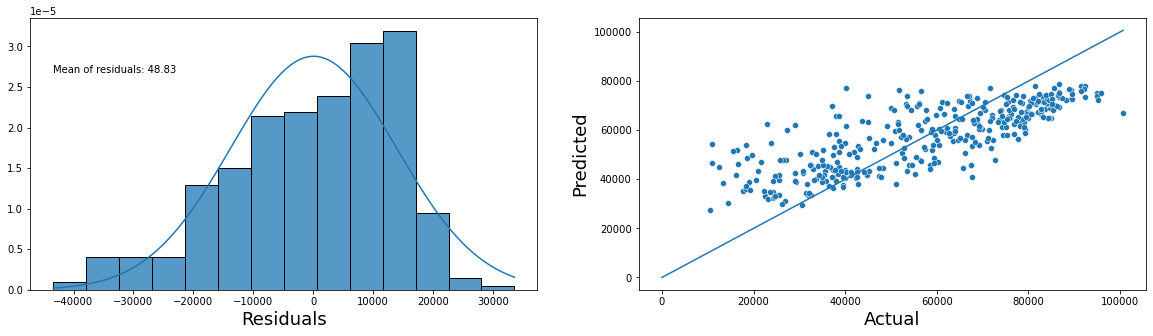

In [ ]:
plot_model_evaluation(df_test, y_test)

In [15]:
def plot_dow_month(df_test,
                   y_test,
                   comparison=None,
                   comparison_title=None,
                   title=None
                  ):
    df = df_test.copy()
    df["count_pred"] = y_test
    if comparison is not None:
        comparison = comparison.copy()[["Month", "Day", "count"]]
        comparison.rename(columns={"count": "comparison"}, inplace=True)
        df = df.merge(comparison, on=["Month", "Day"])    
    df_test_dow = df.groupby(["Day of Week"]).mean().reset_index()
    df_test_month = df.groupby(["Month"]).mean().reset_index()
    df_test_year = df.groupby(["Year"]).mean().reset_index()
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    fig = make_subplots(rows=1, cols=3, subplot_titles=["Month", "Day of Week", "Overall"])

    fig.update_layout(
        barmode='group',
        title_text=title
    )
    
    months = [calendar.month_abbr[i] for i in df_test_month["Month"]]
    dows = [calendar.day_abbr[i] for i in df_test_dow["Day of Week"]]

    if comparison is not None:
        fig.append_trace(go.Bar(name=comparison_title, x=months, y=df_test_month["comparison"], marker_color="#fc8d59"), row=1, col=1)
        fig.append_trace(go.Bar(name=comparison_title, x=dows, y=df_test_dow["comparison"], showlegend=False, marker_color="#fc8d59"), row=1, col=2)
        fig.append_trace(go.Bar(name=comparison_title, x=["Overall"], y=df_test_year["comparison"], showlegend=False, marker_color="#fc8d59"), row=1, col=3)

    fig.append_trace(go.Bar(name='Predicted', x=months, y=df_test_month["count_pred"], marker_color="red"), row=1, col=1)
    fig.append_trace(go.Bar(name='Predicted', x=dows, y=df_test_dow["count_pred"], showlegend=False, marker_color="red"), row=1, col=2)
    fig.append_trace(go.Bar(name='Predicted', x=["Overall"], y=df_test_year["count_pred"], showlegend=False, marker_color="red"), row=1, col=3)
        
    fig.append_trace(go.Bar(name='Actual', x=months, y=df_test_month["count"], marker_color="blue"), row=1, col=1)
    fig.append_trace(go.Bar(name='Actual', x=dows, y=df_test_dow["count"], showlegend=False, marker_color="blue"), row=1, col=2)
    fig.append_trace(go.Bar(name='Actual', x=["Overall"], y=df_test_year["count"], showlegend=False, marker_color="blue"), row=1, col=3)
    
    fig.update_yaxes(title_text="Average daily trips", row=1, col=1)
    
    fig.show()

In [16]:
plot_dow_month(df_test, y_test)

In [18]:
def plot_markers(fig, x, y, color, name):
    fig.add_trace(go.Scatter(x=x,
                             y=y,
                             mode='markers',
                             marker=dict(size=3, color=color),
                             name=name))
    
def plot_lines(fig, x, y, color, window, name):
    fig.add_trace(go.Scatter(x=x,
                             y=y,
                             mode='lines',
                             marker_color=color,
                             name=f'{name}<br>({window}-day average)'))
    

def plot_test(df_test,
              y_test,
              title=None,
              scatter=True,
              ma=True,
              comparison=None,
              comparison_title=None,
              show=True):
    fig = go.Figure()
    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    df = df_test.copy()
    df["count_pred"] = y_test
    
    window = 14
    
    df['count_ma'] = df["count"].rolling(window).mean()    
    df['count_pred_ma'] = df["count_pred"].rolling(window).mean()
    
    if scatter:
        plot_markers(fig, df["date"], df["count"], "blue", "Actual")
        plot_markers(fig, df["date"], df["count_pred"], "red", "Predicted")
        
    if ma:
        plot_lines(fig, df["date"], df["count_ma"], "blue", window, "Actual")
        plot_lines(fig, df["date"], df["count_pred_ma"], "red", window, "Predicted")
    
    if comparison is not None:
        comparison = comparison.copy()[["Month", "Day", "count"]]
        comparison.rename(columns={"count": "comparison"}, inplace=True)
        df = df.merge(comparison, on=["Month", "Day"])        
        df["comparison_ma"] = df["comparison"].rolling(window).mean()
        if scatter: plot_markers(fig, df["date"], df["comparison"], "#fc8d59", comparison_title)
        if ma: plot_lines(fig, df["date"], df["comparison_ma"], "#fc8d59", window, comparison_title)

    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Trips",
        title_text=title
    )
    
    return fig
    
def plot_all(df_train, df_test, y_train, y_test):
    return plot_test(pd.concat([df_train, df_test]), np.append(y_train, y_test))

In [19]:
plot_test(df_test, y_test, "Actual and predicted number of trips in 2019<br>Linear regression with calendar features")

#### Polynomial regression

In [ ]:
df_train, df_test, y_test, y_train, regr = fit_predict(df_nyc, calendar_features, model="polynomial", degree=2)

Training set R2 score: 0.810711495798258
Test set R2 core: 0.6490807735383909
Test set MAPE: 24.1224542531287


#### Polynomial regression with ridge regularization

In [ ]:
df_train, df_test, y_test, y_train, regr = fit_predict(df_nyc, calendar_features, model="ridge", degree=2, alphas=np.logspace(1,3))

Best alpha: 95.40954763499938
Training set R2 score: 0.7992486398072507
Test set R2 core: 0.6535170353206505
Test set MAPE: 24.185788423831095


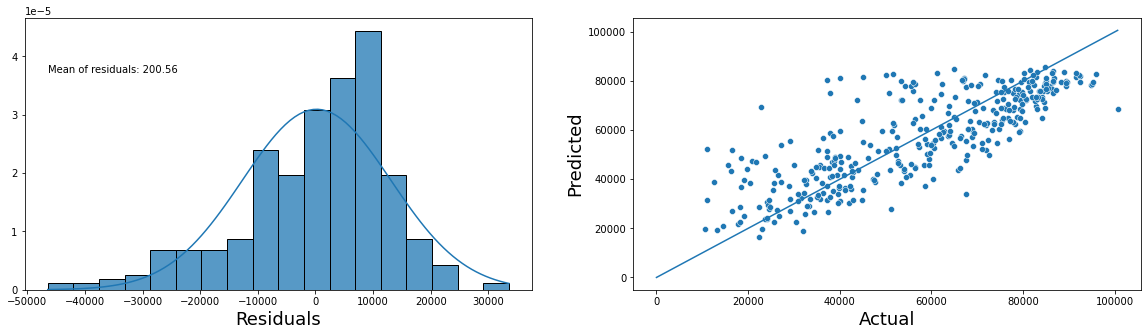

In [ ]:
plot_model_evaluation(df_test, y_test)

In [ ]:
plot_test(df_test,
          y_test,
          "Actual and predicted number of trips in 2019<br>Polynomial regression with regularization using calendar features")

## Adding more features

### Weather
Load weather data. Data has the following columns  
- Wind speed
    - AWND: average wind speed
    - PGTM: peak gust time (missing)
    - WDF*: direction of fastest 1, 2, 5-minute wind
    - WSF*: fastest 1, 2, 5-minute wind
- Temperature
    - TAVG: average (missing)
    - TMAX: maximum
    - TMIN: minimum
- PRCP: precipitation
- SNOW: snowfall
- SNWD: snow depth
- TSUN: sunshine hours (missing)
- Weather types:
    - WT01 - Fog ice fog or freezing fog (may include heavy fog)
    - WT02 - Heavy fog or heaving freezing fog (not always distinguished from fog)
    - WT03 - Thunder
    - WT04 - Ice pellets sleet snow pellets or small hail
    - WT06 - Glaze or rime
    - WT08 - Smoke or haze
    - WT13 - Mist
    - WT14 - Drizzle
    - WT16 - Rain (may include freezing rain drizzle and freezing drizzle)
    - WT18 - Snow snow pellets snow grains or ice crystals
    - WT19 - Unknown source of precipitation
    - WT22 - Ice fog

In [ ]:
pd.set_option('display.max_columns', None)

df_nyc_weather = pd.read_csv("data/nyc/weather.csv", parse_dates=["DATE"])
# Fill NaN values with zeroes
df_nyc_weather.fillna(value="0", inplace=True)
df_nyc_weather["SNOW"] = df_nyc_weather["SNOW"].astype(float)
df_nyc_weather["SNWD"] = df_nyc_weather["SNWD"].astype(float)
df_nyc_weather["AWND"] = df_nyc_weather["AWND"].astype(float)
# Drop values before 01.06.2013
df_nyc_weather = df_nyc_weather[df_nyc_weather["DATE"] >= datetime.strptime("2013-06-01", "%Y-%m-%d")]
df_nyc_weather.tail()

,STATION,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT13,WT14,WT16,WT18,WT19,WT22
2917,USW00094728,2020-12-27,4.03,0,0.00,0.0,0.0,0,37,24,0,150,140,10.1,14.1,0,0,0,0,0,0,0,0,0,0,0,0
2918,USW00094728,2020-12-28,5.37,0,0.00,0.0,0.0,0,50,35,0,270,230,13,19,0,0,0,0,0,0,0,0,0,0,0,0
2919,USW00094728,2020-12-29,8.95,0,0.00,0.0,0.0,0,43,30,0,310,300,19.9,30,0,0,0,0,0,0,0,0,0,0,0,0
2920,USW00094728,2020-12-30,5.14,1903,0.00,0.0,0.0,0,43,28,0,220,210,16.1,29.1,0,0,0,0,0,0,0,0,0,0,0,0
2921,USW00094728,2020-12-31,5.14,0,0.48,0.0,0.0,0,48,36,0,300,300,15,21.9,1,0,0,0,0,0,0,0,0,0,0,0


PGTM, TAVG and TSUN have no data

In [ ]:
weather_types = {
    "WT01": "WT01_fog",
    "WT02": "WT02_heavy_fog",
    "WT03": "WT03_thunder",
    "WT04": "WT04_ice_pellets",
    "WT06": "WT06_glaze",
    "WT08": "WT08_smoke_haze",
    "WT13": "WT13_mist",
    "WT14": "WT14_drizzle",
    "WT16": "WT16_rain",
    "WT18": "WT18_snow_pellets",
    "WT19": "WT19_unknown_precipitation",
    "WT22": "WT22_ice_fog"
}

df_nyc_weather[weather_types.keys()].rename(columns=weather_types).astype(int).sum().sort_values(ascending=False)

WT01_fog                      974
WT08_smoke_haze               491
WT03_thunder                   82
WT02_heavy_fog                 54
WT06_glaze                     14
WT04_ice_pellets                5
WT22_ice_fog                    0
WT19_unknown_precipitation      0
WT18_snow_pellets               0
WT16_rain                       0
WT14_drizzle                    0
WT13_mist                       0
dtype: int64

WT13, WT14, WT16, WT18, WT19, WT22 have no data. Only WT01 and WT08 have a signifcant amount of data points.

In [ ]:
to_drop = ["PGTM", "TAVG", "TSUN"]
to_drop += ['WT13', 'WT14', 'WT16', 'WT18', 'WT19', 'WT22']
df_nyc_weather.drop(columns=to_drop, inplace=True)

In [ ]:
df_nyc = pd.merge(left=df_nyc, right=df_nyc_weather.drop(["STATION"], axis=1), left_on='date', right_on='DATE')
df_nyc.tail()

,date,count,Year,Month,Week,Day,Day of Week,Day of Year,sin_doy,cos_doy,sin_dow,cos_dow,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,holiday,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08
2758,2020-12-27,24040,2020,12,52,27,6,362,-6.861474e-02,0.997643,-0.781831,0.623490,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2020-12-27,4.03,0.00,0.0,0.0,37,24,150,140,10.1,14.1,0,0,0,0,0,0
2759,2020-12-28,39200,2020,12,53,28,0,363,-5.147875e-02,0.998674,0.000000,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2020-12-28,5.37,0.00,0.0,0.0,50,35,270,230,13,19,0,0,0,0,0,0
2760,2020-12-29,33593,2020,12,53,29,1,364,-3.432760e-02,0.999411,0.781831,0.623490,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2020-12-29,8.95,0.00,0.0,0.0,43,30,310,300,19.9,30,0,0,0,0,0,0
2761,2020-12-30,36031,2020,12,53,30,2,365,-1.716633e-02,0.999853,0.974928,-0.222521,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2020-12-30,5.14,0.00,0.0,0.0,43,28,220,210,16.1,29.1,0,0,0,0,0,0
2762,2020-12-31,26626,2020,12,53,31,3,366,-2.449294e-16,1.000000,0.433884,-0.900969,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2020-12-31,5.14,0.48,0.0,0.0,48,36,300,300,15,21.9,1,0,0,0,0,0


#### Exploratory analysis

Plot number of trips against weather as % of yearly max.

In [ ]:
year_max = df_nyc.groupby(["Year"])["count"].max()
df_nyc = pd.merge(left=df_nyc, right=year_max, left_on='Year', right_index=True, suffixes=('', 'max'))

df_nyc["count_mean"] = df_nyc["count"] / df_nyc["countmax"]

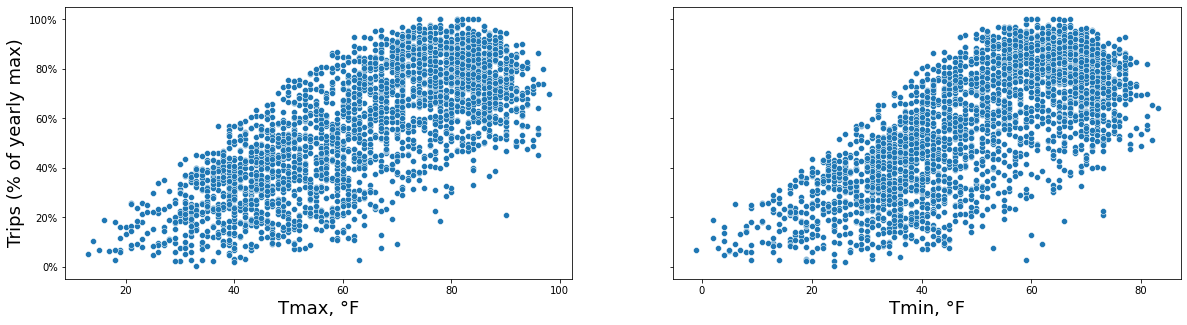

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,5), sharey=True)

sns.scatterplot(x=df_nyc["TMAX"], y=df_nyc["count_mean"], ax=axs[0])
axs[0].set_xlabel('Tmax, °F', fontsize=18)
axs[0].set_ylabel('Trips (% of yearly max)', fontsize=18)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

sns.scatterplot(x=df_nyc["TMIN"], y=df_nyc["count_mean"], ax=axs[1])
axs[1].set_xlabel('Tmin, °F', fontsize=18)
pass

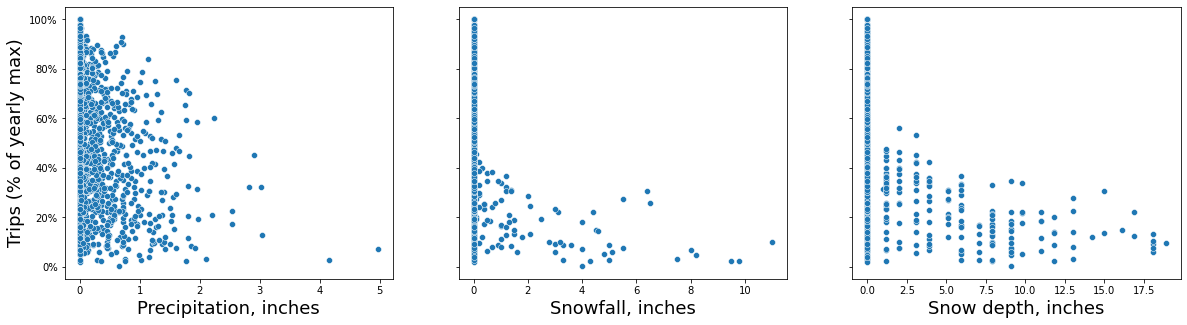

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,5), sharey=True)

sns.scatterplot(x=df_nyc["PRCP"], y=df_nyc["count_mean"], ax=axs[0])
axs[0].set_xlabel('Precipitation, inches', fontsize=18)
axs[0].set_ylabel('Trips (% of yearly max)', fontsize=18)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

sns.scatterplot(x=df_nyc["SNOW"], y=df_nyc["count_mean"], ax=axs[1])
axs[1].set_xlabel('Snowfall, inches', fontsize=18)

sns.scatterplot(x=df_nyc["SNWD"], y=df_nyc["count_mean"], ax=axs[2])
axs[2].set_xlabel('Snow depth, inches', fontsize=18)
pass

Ridership increases with temperature until the hottest days when it drops a bit.  
Ridership drops significantly on days when there is at least some precipitation or snow.

#### Prediction with weather

In [ ]:
df_nyc["PRCP_log"] = np.log(df_nyc["PRCP"] + 1)
df_nyc["SNOW_log"] = np.log(df_nyc["SNOW"] + 1)
df_nyc["SNWD_log"] = np.log(df_nyc["SNWD"] + 1)

In [ ]:
weather_features = ["TMAX", "TMIN", "PRCP_log", "SNOW_log", "SNWD_log"]
wt_columns = ["WT01", "WT08"]
features = [*calendar_features, *weather_features]

df_train, df_test, y_test, y_train, regr = fit_predict(df_nyc, features, model="ridge", degree=2, alphas=np.logspace(1,3,20))

Best alpha: 42.81332398719393
Training set R2 score: 0.932797816124518
Test set R2 core: 0.8683570673747906
Test set MAPE: 13.80077206558534


In [ ]:
plot_test(df_test,
          y_test,
          "Actual and predicted number of trips in 2019<br>Polynomial regression with regularization using calendar and weather features")

In [ ]:
plot_dow_month(df_test,
               y_test,
               title="Actual and predicted number of daily trips in 2019")

### Number of bikes and stations

Load data from monthly reports. Copy data from September 2020 to October and November (no reports available yet).

In [ ]:
df_bikes_stations = pd.read_csv("data/nyc/bikes_stations.csv")
df_bikes_stations["Month"] = pd.to_datetime(df_bikes_stations["Month"])
df_bikes_stations["Year"] = pd.DatetimeIndex(df_bikes_stations["Month"]).year
df_bikes_stations["Month"] = pd.DatetimeIndex(df_bikes_stations["Month"]).month
df_bikes_stations.head()

,Month,Stations,Avg active bikes,EoM fleet,Membership,Year
0,6,322,5130,6000,52130,2013
1,7,328,5531,6000,66315,2013
2,8,332,5681,6000,77138,2013
3,9,332,5513,6000,85241,2013
4,10,332,5623,6000,93124,2013


In [ ]:
df_nyc = df_nyc.merge(df_bikes_stations, on=["Year", "Month"], how="left")
df_nyc.head()

,date,count,Year,Month,Week,Day,Day of Week,Day of Year,sin_doy,cos_doy,sin_dow,cos_dow,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,holiday,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,countmax,count_mean,PRCP_log,SNOW_log,SNWD_log,Stations,Avg active bikes,EoM fleet,Membership
0,2013-06-01,8722,2013,6,22,1,5,152,0.501242,-0.865307,-0.974928,-0.222521,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013-06-01,3.80,0.00,0.0,0.0,90,73,250,260,12.1,19.9,0,0,0,0,0,0,41383,0.210763,0.000000,0.0,0.0,322,5130,6000,52130
1,2013-06-02,15971,2013,6,22,2,6,153,0.486273,-0.873807,-0.781831,0.623490,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013-06-02,6.04,0.85,0.0,0.0,88,69,250,270,15,25.9,1,0,0,0,0,0,41383,0.385931,0.615186,0.0,0.0,322,5130,6000,52130
2,2013-06-03,7598,2013,6,23,3,0,154,0.471160,-0.882048,0.000000,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013-06-03,3.36,0.87,0.0,0.0,78,66,250,250,12.1,19,1,0,0,0,0,0,41383,0.183602,0.625938,0.0,0.0,322,5130,6000,52130
3,2013-06-04,15782,2013,6,23,4,1,155,0.455907,-0.890028,0.781831,0.623490,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013-06-04,4.92,0.00,0.0,0.0,75,57,10,340,13,21,0,0,0,0,0,0,41383,0.381364,0.000000,0.0,0.0,322,5130,6000,52130
4,2013-06-05,15690,2013,6,23,5,2,156,0.440519,-0.897743,0.974928,-0.222521,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2013-06-05,3.80,0.00,0.0,0.0,74,58,160,210,10.1,19,0,0,0,0,0,0,41383,0.379141,0.000000,0.0,0.0,322,5130,6000,52130


In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_nyc["date"], y=df_nyc["Stations"], name="Stations"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_nyc["date"], y=df_nyc["Avg active bikes"], name="Average active bikes"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Monthly number of stations and bikes",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Set y-axes titles
fig.update_yaxes(title_text="Stations", secondary_y=False)
fig.update_yaxes(title_text="Bikes", secondary_y=True)

fig.show()

In [ ]:
features = [*calendar_features, *weather_features, "EoM fleet"]
df_train, df_test, y_test, y_train, regr = fit_predict(df_nyc, features, model="ridge", log=False, degree=2, alphas=np.logspace(0,2))


Best alpha: 22.229964825261945
Training set R2 score: 0.9509307979111913
Test set R2 core: 0.8594911716866305
Test set MAPE: 15.035225130848099


In [ ]:
plot_test(df_test,
          y_test,
          "Actual and predicted number of trips in 2019<br>Polynomial regression with regularization using calendar, weather and system size features")

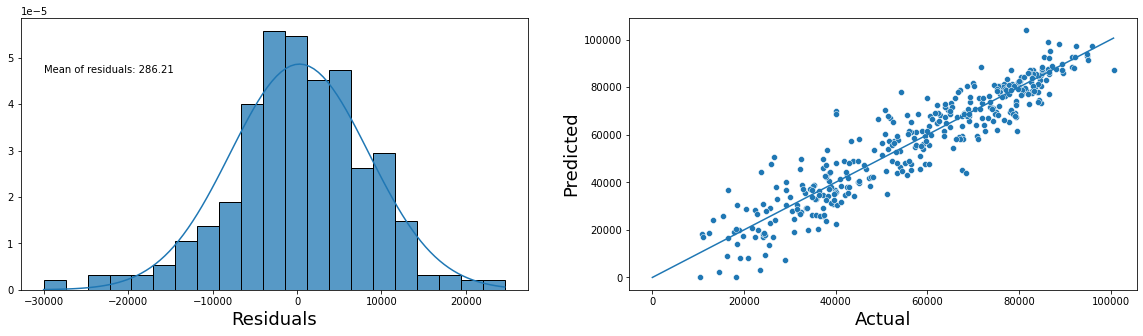

In [ ]:
plot_model_evaluation(df_test, y_test)

In [ ]:
plot_dow_month(df_test,
               y_test,
               title="Actual and predicted number of daily trips in 2019")

## Prediction 2020

In [ ]:
df = df_nyc.copy()
df = df[df["Stations"].notna()]
features = [*calendar_features, *weather_features, "Stations"]

df_train_2020, df_test_2020, y_test_2020, y_train_2020, regr_2020 = fit_predict(df, features, model="ridge", degree=2, alphas=np.logspace(0,2,20), train_year_to=2019, test_year=2020)

Best alpha: 5.455594781168519
Training set R2 score: 0.9557085660980852
Test set R2 core: 0.30773876177599835
Test set MAPE: 45.69939252079513


In [ ]:
df_nyc.tail()

,date,count,Year,Month,Week,Day,Day of Week,Day of Year,sin_doy,cos_doy,sin_dow,cos_dow,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,holiday,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,countmax,count_mean,PRCP_log,SNOW_log,SNWD_log,Stations,Avg active bikes,EoM fleet,Membership
2758,2020-12-27,24040,2020,12,52,27,6,362,-6.861474e-02,0.997643,-0.781831,0.623490,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2020-12-27,4.03,0.00,0.0,0.0,37,24,150,140,10.1,14.1,0,0,0,0,0,0,103403,0.232488,0.000000,0.0,0.0,1166,15442,14813,167556
2759,2020-12-28,39200,2020,12,53,28,0,363,-5.147875e-02,0.998674,0.000000,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2020-12-28,5.37,0.00,0.0,0.0,50,35,270,230,13,19,0,0,0,0,0,0,103403,0.379099,0.000000,0.0,0.0,1166,15442,14813,167556
2760,2020-12-29,33593,2020,12,53,29,1,364,-3.432760e-02,0.999411,0.781831,0.623490,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2020-12-29,8.95,0.00,0.0,0.0,43,30,310,300,19.9,30,0,0,0,0,0,0,103403,0.324875,0.000000,0.0,0.0,1166,15442,14813,167556
2761,2020-12-30,36031,2020,12,53,30,2,365,-1.716633e-02,0.999853,0.974928,-0.222521,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2020-12-30,5.14,0.00,0.0,0.0,43,28,220,210,16.1,29.1,0,0,0,0,0,0,103403,0.348452,0.000000,0.0,0.0,1166,15442,14813,167556
2762,2020-12-31,26626,2020,12,53,31,3,366,-2.449294e-16,1.000000,0.433884,-0.900969,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2020-12-31,5.14,0.48,0.0,0.0,48,36,300,300,15,21.9,1,0,0,0,0,0,103403,0.257497,0.392042,0.0,0.0,1166,15442,14813,167556


In [ ]:
plot_dow_month(df_test_2020,
               y_test_2020,
               title="Actual and predicted number of daily trips in 2020")

Statewide stay-at-home order issued on 22.03.   
Phase 1 reopening 08.06   
Phase 2 reopening 22.06  
Phase 3 reopening 06.07  
Phase 4 reopening 20.07

In [ ]:
fig = plot_test(df_test_2020,
                y_test_2020,
                comparison=df_nyc[df_nyc["Year"] == 2019], 
                comparison_title=2019, 
                show=False,
                scatter=False,
                title="Actual and predicted number of daily trips in 2020 with 2019 for comparison")

fig.add_vrect(
    x0="2020-03-22", x1="2020-06-08",
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0,
    annotation_text="Stay-at-home order",
    annotation_position="top left"
)

fig.add_vrect(
    x0="2020-06-08", x1="2020-07-20",
    fillcolor="LightGreen", opacity=0.5,
    layer="below", line_width=0,
    annotation_text="Reopening",
    annotation_position="top left"
)

fig.show()

In [ ]:
df_nyc[df_nyc["Year"] == 2019].head()

,date,count,Year,Month,Week,Day,Day of Week,Day of Year,sin_doy,cos_doy,sin_dow,cos_dow,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,holiday,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,countmax,count_mean,PRCP_log,SNOW_log,SNWD_log,Stations,Avg active bikes,EoM fleet,Membership
2032,2019-01-01,22393,2019,1,1,1,1,1,0.017213,0.999852,0.781831,0.623490,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2019-01-01,0.0,0.06,0.0,0.0,58,39,0,0,0,0,1,0,0,0,0,0,100658,0.222466,0.058269,0.0,0.0,757,11500,10961,151534
2033,2019-01-02,38624,2019,1,1,2,2,2,0.034422,0.999407,0.974928,-0.222521,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-01-02,0.0,0.00,0.0,0.0,40,35,0,0,0,0,0,0,0,0,0,0,100658,0.383715,0.000000,0.0,0.0,757,11500,10961,151534
2034,2019-01-03,42536,2019,1,1,3,3,3,0.051620,0.998667,0.433884,-0.900969,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-01-03,0.0,0.00,0.0,0.0,44,37,0,0,0,0,0,0,0,0,0,0,100658,0.422579,0.000000,0.0,0.0,757,11500,10961,151534
2035,2019-01-04,44822,2019,1,1,4,4,4,0.068802,0.997630,-0.433884,-0.900969,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-01-04,0.0,0.00,0.0,0.0,47,35,0,0,0,0,0,0,0,0,0,0,100658,0.445290,0.000000,0.0,0.0,757,11500,10961,151534
2036,2019-01-05,17740,2019,1,1,5,5,5,0.085965,0.996298,-0.974928,-0.222521,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-01-05,0.0,0.50,0.0,0.0,47,41,0,0,0,0,1,0,0,0,0,0,100658,0.176240,0.405465,0.0,0.0,757,11500,10961,151534


In [ ]:
df = df_test_2020[df_test_2020["Month"] > 7].copy()
comparison = df_nyc.loc[(df_nyc["Year"]==2019) & (df_nyc["Month"]>7)]
plot_dow_month(
    df,
    y_test_2020[-len(df.index):],
    comparison=comparison,
    comparison_title="2019",
    title="Actual and predicted number of daily trips in August-December 2020 with 2019 for comparison")